In [130]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn import svm
from typing import List

In [131]:
# display formatting for floats
pd.options.display.float_format = '{:,.2f}'.format

In [132]:
df = pd.read_csv('processed.csv')

In [133]:
exclude_features = [
    'TokenId', 'LastSalePrice', 'LastSaleToken',
    'SaleDate', 'USDPrice', 'USDPriceEWM', 'PctExtensionEWM',
    'PctExtensionEWMScaled'
]
# remove the rarity features since they are completely correlated with the categoricals
exclude_features.extend([feature for feature in df.columns if 'Rarity' in feature])
features = [feature for feature in df.columns if feature not in exclude_features]

In [134]:
X = df.loc[:, features]
y = df['PctExtensionEWMScaled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Model Selection

In [135]:
def model_selection(models: List[dict], scores: List[str], X_train, y_train) -> dict:
    """Find the best model"""
    results = {}
    for candidate in models:
        model = GridSearchCV(
            candidate['constructor'], param_grid=candidate['param_grid'], scoring=scores
        )
        model.fit(X_train, y_train)
        mean_test_score = model.cv_results_['mean_test_score'].mean()
        results[candidate['name']] = mean_test_score
    print("The winner is: {}".format(
        max(results, key=results.get)
    ))
    return results

In [136]:
models = [
    {
        'name': 'LinearRegression',
        'constructor': LinearRegression(),
        'param_grid': {}
    },
    {
        'name': 'RandomForest',
        'constructor': RandomForestRegressor(random_state=0),
        'param_grid': {}
    },
    {
        'name': 'Huber',
        'constructor': HuberRegressor(),
        'param_grid': {'epsilon': [3, 5], 'max_iter': [800]}
    }
]
model_selection(models, 'neg_root_mean_squared_error', X_train, y_train)

The winner is: Huber


{'LinearRegression': -0.29138514845578356,
 'RandomForest': -0.29799584700111303,
 'Huber': -0.29060667569340926}

In [123]:
model = LinearRegression().fit(X_train, y_train)
y_actual, y_pred = y_test, model.predict(X_test)
predict_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})

In [124]:
metrics.mean_squared_error(y_test, y_pred)

0.03288528756606573

In [125]:
metrics.mean_absolute_error(y_test, y_pred)

0.10955962534559083

In [111]:
predicted_merged = df.merge(predict_df, how='left', left_index=True, right_index=True)
predicted_merged = predicted_merged.loc[~predicted_merged['Predicted'].isna()]

In [112]:
cols = predicted_merged.columns[0:]
pm = predicted_merged.loc[:, ['TokenId', 'SaleDate', 'USDPriceEWM', 'Actual', 'Predicted', 'USDPrice', 'PctExtensionEWM']]

In [113]:
pm['PredictedUSDPrice'] = pm['USDPriceEWM'] * (1 + np.exp(pm['Predicted']) - 2)

In [114]:
pm.sample(10)

,TokenId,SaleDate,USDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice
6751,2756,2021-08-29 06:09:31.069553,"195,464.08",0.66,0.70,"183,863.26",-0.06,"197,831.09"
6756,4048,2021-08-29 08:12:58.347661,"197,430.79",0.74,0.64,"215,066.77",0.09,"178,006.65"
807,6209,2021-05-02 19:32:51.688379,"3,355.29",0.68,0.77,"3,293.31",-0.02,"3,876.96"
5389,5332,2021-08-01 19:49:16.979982,"42,993.44",0.62,0.64,"36,843.93",-0.14,"38,552.34"
927,9374,2021-05-03 00:18:45.971249,"3,034.31",0.52,0.67,"2,055.05",-0.32,"2,893.40"
4902,182,2021-07-17 00:09:58.883227,"31,120.93",0.60,0.57,"25,474.68",-0.18,"23,901.83"
3014,593,2021-06-07 11:12:00.135966,"7,202.13",0.76,0.62,"8,189.90",0.14,"6,130.74"
1832,5500,2021-05-20 11:55:22.800064,"1,755.19",0.66,0.69,"1,649.49",-0.06,"1,729.37"
764,8348,2021-05-02 18:13:04.668143,"1,857.22",0.63,0.58,"1,642.54",-0.12,"1,475.95"
6126,2645,2021-08-21 01:30:04.433037,"101,602.74",0.58,0.64,"79,851.52",-0.21,"90,756.04"


In [115]:
pm['Accuracy'] = 1 - abs(pm['PredictedUSDPrice'] - pm['USDPrice']) / ((pm['PredictedUSDPrice'] + pm['USDPrice']) / 2)

In [116]:
pm.sort_values('Accuracy', ascending=False).tail(20)

,TokenId,SaleDate,USDPriceEWM,Actual,Predicted,USDPrice,PctExtensionEWM,PredictedUSDPrice,Accuracy
677,7956,2021-05-02 14:21:35.124516,"4,598.12",0.24,0.63,"1,234.99",-0.73,"4,050.16",-0.07
347,3072,2021-05-01 21:37:54.863153,"1,551.30",1.36,2.36,"4,503.80",1.90,"14,800.44",-0.07
3580,5501,2021-06-17 13:59:00.894387,"13,336.71",1.73,0.87,"61,749.60",3.63,"18,523.19",-0.08
468,1232,2021-05-02 03:06:17.942644,"1,116.43",1.54,0.74,"4,094.95",2.67,"1,227.36",-0.08
2722,8577,2021-06-03 12:36:27.907681,"5,026.15",1.70,0.83,"22,605.60",3.50,"6,490.92",-0.11
1032,8408,2021-05-03 05:09:17.027961,"2,491.87",1.64,0.78,"10,291.60",3.13,"2,951.20",-0.11
1833,5708,2021-05-20 14:02:38.022520,"1,739.53",2.09,1.11,"12,349.92",6.10,"3,539.83",-0.11
37,3584,2021-05-01 08:23:07.457600,403.40,2.21,1.19,"3,275.49",7.12,923.08,-0.12
2034,2429,2021-05-28 03:08:05.314815,"2,246.35",1.72,0.82,"10,237.38",3.56,"2,845.53",-0.13
856,6736,2021-05-02 21:14:10.268598,"2,238.89",1.72,0.82,"10,291.60",3.60,"2,837.04",-0.14


In [117]:
def valuate(token_id, df, features, current_price_ewa):
    token_data = df.loc[df['TokenId']==token_id, features]
    y_pred = model.predict(token_data)
    return float(current_price_ewa * (1 + y_pred))

In [118]:
valuate(9361, df, features, df.sort_values('SaleDate', ascending=False)['USDPriceEWM'].iloc[0])

756259.6116017429

In [119]:
import seaborn as sns

<AxesSubplot:xlabel='Accuracy', ylabel='Count'>

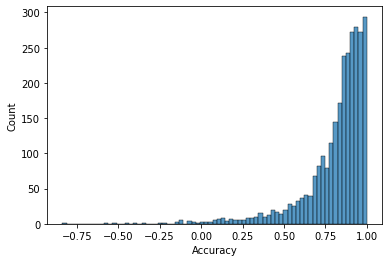

In [120]:
sns.histplot(pm['Accuracy'])

## Stacking

In [106]:
from sklearn.ensemble import VotingRegressor

In [92]:
estimators = [('randomforest', RandomForestRegressor(random_state=42)),
              ('linear', LinearRegression()),
              ('huber', HuberRegressor(epsilon=5, max_iter=800))]

In [107]:
ereg = VotingRegressor(estimators)

In [108]:
ereg.fit(X_train, y_train)

VotingRegressor(estimators=[('randomforest',
                             RandomForestRegressor(random_state=42)),
                            ('linear', LinearRegression()),
                            ('huber', HuberRegressor(epsilon=5, max_iter=800))])

In [109]:
y_actual, y_pred = y_test, ereg.predict(X_test)
predict_df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
from sklearn import metrics
-metrics.mean_squared_error(y_test, y_pred)

-0.03194413891310145

In [126]:
metrics.mean_absolute_error(y_test, y_pred)

0.10955962534559083

In [129]:
cross_validate(ereg, X_train, y_train, cv=3,
               scoring=('r2', 'neg_mean_squared_error'),
               return_train_score=True)

{'fit_time': array([7.61779213, 7.52373958, 8.06214786]),
 'score_time': array([0.08537173, 0.09670281, 0.09707713]),
 'test_r2': array([0.64159113, 0.67477462, 0.67572834]),
 'train_r2': array([0.8162314 , 0.80844377, 0.81071263]),
 'test_neg_mean_squared_error': array([-0.03243291, -0.02776962, -0.0255343 ]),
 'train_neg_mean_squared_error': array([-0.0150842 , -0.01620904, -0.0166498 ])}